<a href="https://colab.research.google.com/github/onedayzero/food-sales-predictions/blob/main/food_sales_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Sales Predictions
-Clint Atterberry

-17 June 2022

## Mount the drive, import libraries, and import data

In [ ]:
# Import Library pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, \
OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='diagram')

In [ ]:
# Get csv data from link for assignment
filename= ('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ9hM0TmmxdZ3whTnYlhnTpQR0bVvUFganKildu6gE-u4P5hMtFyr0VXkgZ6b8IfBvC148lRAvmgAXU/pub?output=csv')
df = pd.read_csv(filename)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
# This will display the (rows, columns) of the data frame
df.shape

(8523, 12)

## What are the datatypes of each variable?

- objects (strings) - 'Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_type'

- float64 (floats) - 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'

- int64 (integers) - 'Outlet_Establishment_Year'

In [ ]:
# This will display the data types of the variables
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Are there duplicates? If so, drop any duplicates.

- There are no duplicate rows; therefore, there are no rows to drop.

In [ ]:
# This will display the counts of the duplicated rows
df.duplicated().value_counts()

False    8523
dtype: int64

## Identify missing values.

- There are 2 rows that appear to have missing values:

- Item_Weight is missing 1463 values

- Outlet_Size is missing 2410 values

- There may be more missing values in other columns but they may have a placeholder (like 'missing') in its place in the column. Item_Visibility has some values that are 0, so those may be missing values.

In [ ]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## Decide on how to address the missing values and do it!

In [ ]:
# We have 82.8% of the data
df['Item_Weight'].describe()

# With over 7000 data values and 1600 missing values
# There are no outliers in the data set when considering both the mean and the median
# The mean + 2 standard deviations from the mean captures no data points
# The median +- 1.5 * the IQR produces fences that are beyond both the min and max

# I believe the best course of action is to use the mean and filling in the gaps of the missing data points
# I chose the mean over the median because the mean is very close to the middle of the max and the min (~12.9)

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

In [ ]:
# We have 71.7% of the data
df['Outlet_Size'].value_counts()

# With nearly 30% of the values missing the size of the outlet
# The counts are not very close considering ~45% of the known data is Medium, ~39% of the data is known small, and the rest (~15%) is High
# One might consider filling in the missing values with the mode, Medium
# I believe that would be filling in too much data, nearly 30%, with one value will not be the best representation
# Due to the size of the missing data and that it is categorical, either deleting those rows or filling in the data with "Missing" would be the best course of action
# There is a other, similar columns like 'Outlet_Location_Type'and 'Outlet_Type' that probably describes the data in similar way

# I believe the best course of action at this time is to remove the entire column
# I am basing this decision on the fact that there are similar columns to 'Outlet_Size' like 'Outlet_Type' and 'Outlet_Location_Type'

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [ ]:
# Dropping Outlet_Establishment_Year because it is information that appears to
# not be useful when analyzing the data

## Checking in:

- We will drop the 'Outlet_Size' and 'Outlet_Establishment_Year' column

- We will fill in the missing values in 'Item_Weight'


In [ ]:
# We are going to start by getting rid of the columns 'Outlet_Size' and
# 'Outlet_Establishment_Year'
df.drop(columns=['Outlet_Size','Outlet_Establishment_Year'], inplace=True)

In [ ]:
# We are going to fill in the missing values with the mean value of the column

# Saving the mean as a variable 'weight_mean'
weight_mean = df['Item_Weight'].mean()

# Dropping the 'na' values with the 'weight_mean' variable
df['Item_Weight'].fillna(weight_mean, inplace=True)

## Confirm that there are no missing values after addressing them.

- We will explore the sum of missing values from our dataframe

In [ ]:
# Finding the sum of missing values across the data frame
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Success!

- Our data frame now has no missing values

## Find and fix any inconsistent categories of data

- We will pull up all of the category names and verify the capitalization is consistent and there are no spaces

In [ ]:
# I will infestigate the columns made of strings

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


In [ ]:
# Here are some inconsistencies I need to fix with Low Fat and Regular

df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
# This will replace the LF and low fat to both Low Fat, and reg to Regular

df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'}, inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
# No changes need to be made

df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [ ]:
# No changes need to be made

df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [ ]:
# No changes need to be made

df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [ ]:
# No changes need to be made

df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

## For any numerical columns, obtain the summary statistics of each (min, max, mean)

- There numerical columns we will explore are:
1.   Item_Weight
2.   Item_Visibility
3.   Item_MRP
4.   Item_Outlet_Sales

In [ ]:
# Item_Weight summary statistics
df['Item_Weight'].describe()

count    8523.000000
mean       12.857645
std         4.226124
min         4.555000
25%         9.310000
50%        12.857645
75%        16.000000
max        21.350000
Name: Item_Weight, dtype: float64

## Summary Statistics for 'Item_Weight'
- min = 4.55
- max = 21.35
- mean = 12.86

In [ ]:
# Item_Visibility summary statistics
df['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

## Summary Statistics for 'Item_Visibility'
- min = 0
- max = 0.33
- mean = 0.07

In [ ]:
# Item_MRP summary statistics
df['Item_MRP'].describe()

count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

## Summary Statistics for 'Item_MRP'
- min = 31.29
- max = 266.89
- mean = 140.99

In [ ]:
# Outlet_Establishment_Year summary statistics
df['Outlet_Establishment_Year'].describe()

count    8523.000000
mean     1997.831867
std         8.371760
min      1985.000000
25%      1987.000000
50%      1999.000000
75%      2004.000000
max      2009.000000
Name: Outlet_Establishment_Year, dtype: float64

## Summary Statistics for 'Outlet_Establishment_Year'
- min = 1985
- max = 2009
- mean = 1997

In [ ]:
# Item_Outlet_Sales summary statistics
df['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

## Summary Statistics for 'Item_Outlet_Sales'
- min = 33.29
- max = 13,086.96
- mean = 2181.29

## Plot histograms of the following:
1. Item Weight
2. Item Visibility
3. Item MRP
4. Item Outlet Sales.

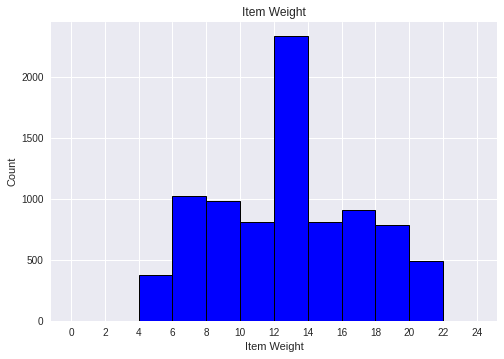

In [ ]:
# Histogram for Item Weight

x = df['Item_Weight']
y = [0,2,4,6,8,10,12,14,16,18,20,22,24]

plt.style.use('seaborn')
plt.hist(x,y,ec='black', lw=1, fc=(0,0,1,1))

plt.xlabel('Item Weight')
plt.ylabel('Count')
plt.title('Item Weight')
plt.xticks(y)
plt.show()

## Initial Analysis

- Center - The item weight is centered around 13.

- Shape - The item weight data is unimodal and symmetrical.

- Spread - The item weight data spans from 4 to 22.

- Anything Unusual - This graph has a large spike around 13. This is due to the
missing data from this column being filled in with the mean value.

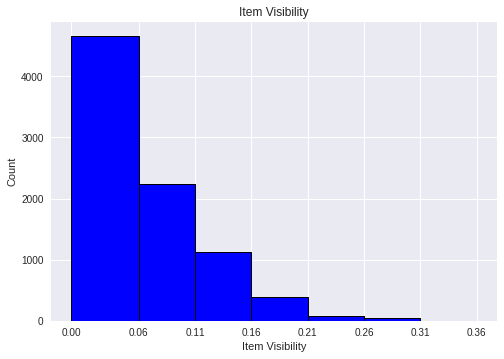

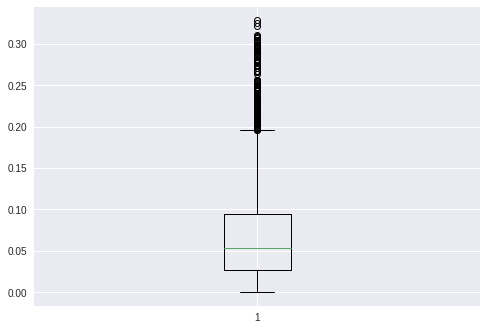

In [ ]:
# Histogram for Item Visibility

x = df['Item_Visibility']
y = [0,0.06,0.11,0.16,0.21,0.26,0.31,0.36]

plt.style.use('seaborn')
plt.hist(x,y,ec='black', lw=1, fc=(0,0,1,1))

plt.xlabel('Item Visibility')
plt.ylabel('Count')
plt.title('Item Visibility')
plt.xticks(y)
plt.show()

# Because the histogram is skewed, I will look at the boxplot
plt.boxplot(df['Item_Visibility']);

## Initial Analysis

- Center - The item visibility data is centered is around 0.05.

- Shape - The item visibility data is skewed to the right.

- Spread - The item visibility data is primarily spread from 0 to 0.2. However, there are some outliers above 0.2 and below 0.35.

- Anything Unusual - There are a number of outliers in this data set that are above the upper fence (which is around 0.2).

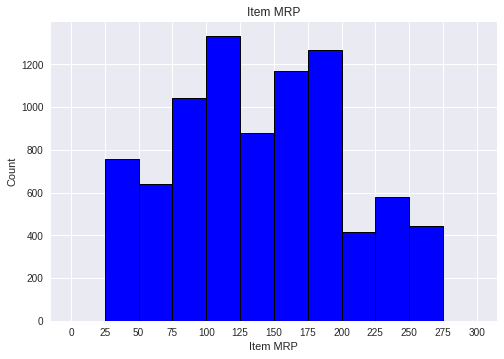

In [ ]:
# Histogram for Item MRP

x = df['Item_MRP']
y = [0,25,50,75,100,125,150,175,200,225,250,275,300]
     
plt.style.use('seaborn')
plt.hist(x,y,ec='black', lw=1, fc=(0,0,1,1))

plt.xlabel('Item MRP')
plt.ylabel('Count')
plt.title('Item MRP')
plt.xticks(y)
plt.show()

## Initial Analysis

- Center - The center of the Item MRP data is around 150.

- Shape - The Item MRP data is fairly unimodal and symmetrical.

- Spread - The Item MRP data spans from 25 to 275.

- Anything Unusual - The data is fairly unimodal; however, the data could be interpretted to actually be multimodal. This data might be looked at in 3 sections, 25-125, 125-200, and 200-275. More data would need to be collected to make a better determination.

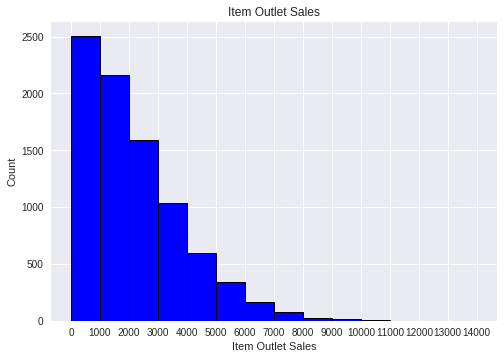

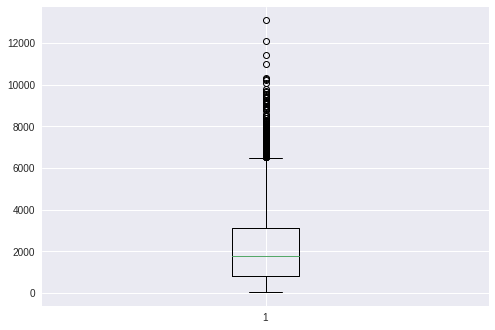

In [ ]:
# Histogram for Item Visibility

x = df['Item_Outlet_Sales']
y = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000]

plt.style.use('seaborn')
plt.hist(x,y,ec='black', lw=1, fc=(0,0,1,1))

plt.xlabel('Item Outlet Sales')
plt.ylabel('Count')
plt.title('Item Outlet Sales')
plt.xticks(y)
plt.show()

# Because the histogram is skewed, I will look at the boxplot
plt.boxplot(df['Item_Outlet_Sales']);

## Initial Analysis

- Center - The item outlet sales data is centered around the value of 2000.

- Shape - The item outlet sales data is skewed to the right.

- Spread - The item outlet sales data spreads from 0 to a little over 6000. However, outliers can be found all the way out past 12,000.

- Anything Unusual - The data is very skewed to the right and has a lot of outliers that go out to twice the distance from the minimum value to the upper fence.

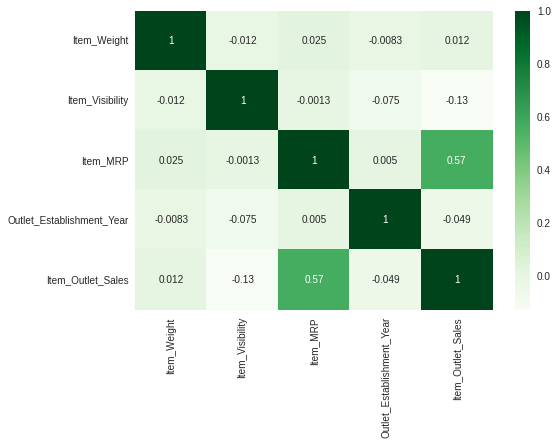

In [ ]:
# Creating a heat map of the data
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True);

## Initial Analysis

The data seems to have almost 0 correlation with the exception of the item MRP and the item outlet sales (r = 0.57). More investigation into all of the data sets should be considered, some data might have more of a correlation if spliced into different sections.

In [ ]:
## functionize the above plot and call it plot_dist
def plot_dist(data, x='Item_Outlet_Sales', figsize=(10,5)):
  ## Make a larger fig/ax before plotting
  fig, ax = plt.subplots(figsize=figsize)

  ## Plot histogram
  sns.histplot(data=df, x=x, ax=ax)
  ax.set(title='Item Outlet Sales Data');

  ## Annotate mean and median
  mean_price = df[x].mean()
  ax.axvline(mean_price, color='slategray', ls=':', lw=3,
            label=f'Mean Price = ${mean_price:,.2f}');

  med_price = df[x].median()
  ax.axvline(med_price, color='skyblue', ls=':', lw=3,
            label=f'Median Price = ${med_price:,.2f}');

  ax.legend();
  return fig, ax

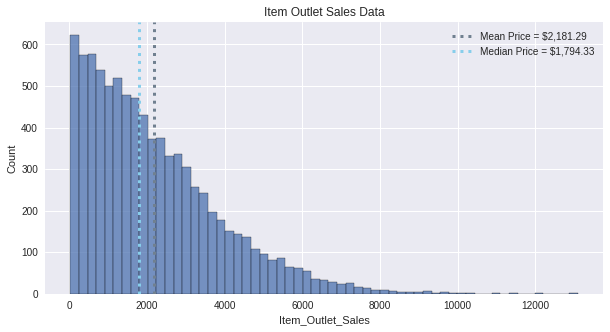

In [ ]:
fig, ax = plot_dist(df)

The mean and median have a significant gap. The mean outlet sales are almost $400 more than the median outlet sales. This is due to the data being skewed to the right. When exploring this data more, the median will be the best choice for the middle point of the data.

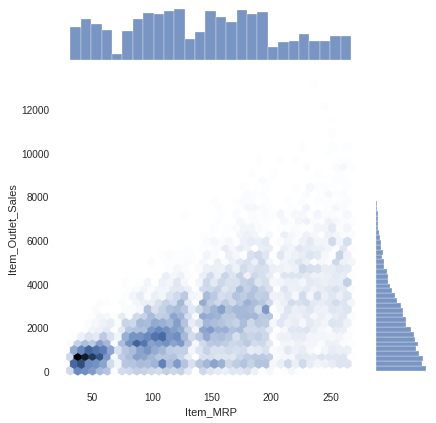

In [ ]:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
# as reference

with sns.axes_style('white'):
    sns.jointplot(df['Item_MRP'], df['Item_Outlet_Sales'], data=df, kind='hex');

This graph clearly shows that there are 4 clusters of data. It appears that as the item MRP increase, the outlet sales decreases.

## Outlet Type Comparison

In [ ]:
df['Outlet_Type']

0       Supermarket Type1
1       Supermarket Type2
2       Supermarket Type1
3           Grocery Store
4       Supermarket Type1
              ...        
8518    Supermarket Type1
8519    Supermarket Type1
8520    Supermarket Type1
8521    Supermarket Type2
8522    Supermarket Type1
Name: Outlet_Type, Length: 8523, dtype: object

In [ ]:
market_filter = df['Outlet_Type'].value_counts()

In [ ]:
outlet_labels = df['Outlet_Type'].unique()

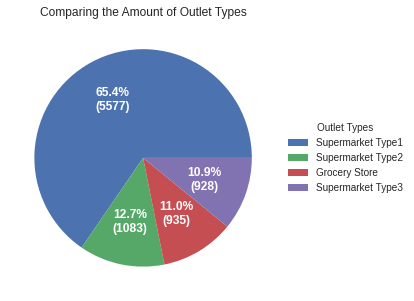

In [ ]:
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
# as reference
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(market_filter, autopct=lambda pct: func(pct, market_filter),
                                  textprops=dict(color="w"), radius = 1)

ax.legend(wedges, outlet_labels,
          title="Outlet Types",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Comparing the Amount of Outlet Types")

plt.show()

The most common type of outlet is Supermarket Type 1. The other outlet types are all fairly similar in quantity.

# Data Prep for Machine Learning

In [ ]:
df_ml = pd.read_csv(filename)
df_ml

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [ ]:
# Check to see if there are any duplicates
df_ml.duplicated().sum()

0

In [ ]:
# Look at the info from the data
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Features (numerical, ordinal, or nominal)

### numerical
Item_Weight, Item_Visibility, Item_MRP, Outlet_Establishment_Year, Item_Outlet_Sales

### ordinal
Item_Fat_Content, Outlet_Size, Outlet_Location_Type

### nominal
Item_Type, Outlet_Type

In [ ]:
df_ml = df_ml.drop(columns=['Item_Identifier','Outlet_Identifier'])

In [ ]:
for col in df_ml.select_dtypes(include='object').columns:
  display(df_ml[col].value_counts())
  print('\n')

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [ ]:
# This will replace the LF and low fat to both Low Fat, and reg to Regular
df_ml['Item_Fat_Content'].replace({'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'}, inplace=True)
df_ml['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
# Ordinal Encoding 'Item_Fat_Content'
replacement_dictionary = {'Low Fat':0, 'Regular':1}
df_ml['Item_Fat_Content'].replace(replacement_dictionary, inplace=True)
df_ml['Item_Fat_Content']

# Ordinal Encoding 'Outlet_Size'
replacement_dictionary = {'Small':0, 'Medium':1, 'High':2}
df_ml['Outlet_Size'].replace(replacement_dictionary, inplace=True)
df_ml['Outlet_Size']

# Ordinal Encoding 'Outlet_Location_Type'
replacement_dictionary = {'Tier 1':0, 'Tier 2':1, 'Tier 3':2}
df_ml['Outlet_Location_Type'].replace(replacement_dictionary, inplace=True)
df_ml['Outlet_Location_Type']


0       0
1       2
2       0
3       2
4       2
       ..
8518    2
8519    1
8520    1
8521    2
8522    0
Name: Outlet_Location_Type, Length: 8523, dtype: int64

In [ ]:
# split X and y, you are predicting price
X = df_ml.drop(columns=['Item_Outlet_Sales'])
y = df_ml['Item_Outlet_Sales']

# split training and test
# set random_state to 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [ ]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [ ]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [ ]:
# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff0cf782910>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff0cf782e10>)])

In [ ]:
# fit on train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff0cf782910>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff0cf782e10>)])

In [ ]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 27)




array([[ 0.81724868, -0.7403206 , -0.71277507, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 ,  1.35076614, -1.29105225, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.35076614,  1.81331864, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.7403206 , -0.92052713, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.7403206 , -0.2277552 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.7403206 , -0.95867683, ...,  1.        ,
         0.        ,  0.        ]])

Now all of our transformations are complete and we are ready for modeling! We can see that the numeric columns have been scaled and the categorical columns have been encoded as numbers. All of the columns are now listed as numeric columns and are ready for machine learning. Mission accomplished!